In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, MobileNet, ResNet50
from tensorflow.keras.preprocessing import image

In [2]:
pip install missinglink  --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host files.pythonhosted.org

^C
Note: you may need to restart the kernel to use updated packages.


In [7]:
def plot_predictions_for_class(data, class_id, figsize=(10,7)):
    """
    Plots the distribution of the predictions given a label
    """
    subset = data[data["Labels"] == class_id]
    plt.figure(figsize=figsize)
    plt.title("Count per Predicted Label")
    plt.xlabel("Food Item")
    plt.ylabel("Count")
    value_counts = subset["Predictions"].value_counts().plot(kind="bar")
    return value_counts

def get_most_accurate(data, k=1):
    """
    Returns top k most accurate predictions
    """
    subset = data[data["Labels"]==data["Predictions"]]
    results = (subset["Labels"].value_counts()/data["Labels"].value_counts()).sort_values(ascending=False)[:k]
    return results

In [8]:
batch_size = 32
shape = (224, 224)

# data augmentation
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True, # randomly flip images
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.05, # randomly zoom image
    brightness_range=[0.4, 0.8],
    fill_mode="reflect"
    ) 

train_generator = datagen.flow_from_directory(
    directory="images/train",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

valid_generator = datagen.flow_from_directory(
    directory="images/valid",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

test_generator = datagen.flow_from_directory(
    directory="images/test",
    target_size=shape,
    color_mode="rgb",
    shuffle=False,
    batch_size=1,
    class_mode="categorical")

num_classes = len(train_generator.class_indices)

# create step size
STEP_SIZE_TRAIN=np.ceil(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=np.ceil(valid_generator.n/valid_generator.batch_size)
STEP_SIZE_TEST=np.ceil(test_generator.n/test_generator.batch_size)

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

Found 3448 images belonging to 101 classes.
Found 2423 images belonging to 101 classes.
Found 3022 images belonging to 101 classes.
108.0
76.0
3022.0


In [9]:
# callbacks
earlyStopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint = ModelCheckpoint(os.path.join("models", "model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), verbose=1, 
                             monitor="val_loss", save_best_only=True, mode="auto")
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode="min")

In [10]:
#pip install missinglink --trusted-host pypi.org

In [11]:
import missinglink
missinglink_callback = missinglink.KerasCallback()

ModuleNotFoundError: No module named 'missinglink'

In [ ]:
# fit base model
#model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=valid_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    callbacks=[earlyStopping, checkpoint, reduce_lr_loss],
#                    epochs=1, verbose=2)

## Transfer Learning => VGG 

In [37]:
# load base MobileNet
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(shape[0], shape[1], 3))

In [38]:
top_block = base_vgg16.output

top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer
vgg_transfer = Model(inputs=base_vgg16.input, outputs=predictions)

In [39]:
vgg_transfer.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["acc"])

In [49]:
# fit model
checkpoint = ModelCheckpoint(os.path.join("models", "model-vgg16-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_vgg = vgg_transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[missinglink_callback,earlyStopping, checkpoint],
                                       epochs=10, verbose=2)

Train for 5.0 steps, validate for 2.0 steps


//anaconda3/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.47636, saving model to models/model-vgg16-001-0.992424-0.727273.h5
5/5 - 112s - loss: 0.0228 - acc: 0.9924 - val_loss: 1.4764 - val_acc: 0.7273
Epoch 2/10

Epoch 00002: val_loss did not improve from 1.47636
5/5 - 113s - loss: 0.0055 - acc: 1.0000 - val_loss: 1.4857 - val_acc: 0.7045
Epoch 3/10

Epoch 00003: val_loss improved from 1.47636 to 1.37226, saving model to models/model-vgg16-003-1.000000-0.681818.h5
5/5 - 110s - loss: 0.0097 - acc: 1.0000 - val_loss: 1.3723 - val_acc: 0.6818
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.37226
5/5 - 111s - loss: 2.2465 - acc: 0.5909 - val_loss: 1.8213 - val_acc: 0.3182
Epoch 5/10


ExperimentStopped: Experiment was stopped.

In [ ]:
# unfreeze last few layers
for i, layer in enumerate(reversed(vgg_transfer.layers)):
    layer.trainable = True
    if i > 8:
        break

In [67]:
#load model
vgg_transfer= load_model(os.path.join("models", "model-vgg16-001-0.992424-0.727273.h5"))

In [51]:
import missinglink
missinglink_callback = missinglink.KerasCallback()

In [68]:
# evaluate
val_loss, val_acc = vgg_transfer.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print("Val Loss: {} \nVal Accuracy: {}".format(val_loss, val_acc))

2/2 [==============================] - 37s 19s/step - loss: 0.9063 - acc: 0.6818
Val Loss: 0.906295470893383 
Val Accuracy: 0.6818181872367859


In [53]:
# predict valid images
pred = vgg_transfer.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1)

2/2 [==============================] - 18s 9s/step


In [121]:
# clean predictions
predictions = pred.argmax(axis=-1)
labels = (valid_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predictions]

In [127]:
# create prediction dataframe
filenames = valid_generator.filenames
correct_labels = [filename[:filename.find("\\")] for filename in filenames]
results = pd.DataFrame({"Labels": correct_labels, "Predictions": predicted_labels})

In [129]:
# results

In [ ]:
get_most_accurate(results,10)

In [1]:
# plot_predictions_for_class(results, "baby back ribs")

Actual: bread pudding
Predicted: bread pudding


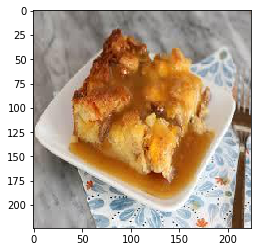

In [95]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)
head, sep, tail = random_image.partition('.')
head = head.replace("_","")
random_image = ''.join([i for i in head if not i.isdigit()])
print("Actual:", random_image)
print("Predicted:", labels[vgg_transfer.predict(img).argmax(axis=-1)[0]])

In [131]:

for k in range(1,10):
    source = "test"
    random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
    random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
    img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
#     plt.imshow(img)
    img = image.img_to_array(img) / 255
    img = np.expand_dims(img, axis = 0)
    head, sep, tail = random_image.partition('.')
    head = head.replace("_","")
    random_image = ''.join([i for i in head if not i.isdigit()])
    
#     pd.DataFrame({"actual":random_image,"Predicted":labels[vgg_transfer.predict(img).argmax(axis=-1)[0]]})
    print("Actual:", random_image)
    print("Predicted:", labels[vgg_transfer.predict(img).argmax(axis=-1)[0]])
    print("========================")
    

Actual: beet salad
Predicted: beet salad
Actual: apple pie
Predicted: bread pudding
Actual: beef tartare
Predicted: beef carpaccio
Actual: beef tartare
Predicted: beef carpaccio
Actual: bread pudding
Predicted: bread pudding
Actual: beef tartare
Predicted: beef tartare
Actual: beef carpaccio
Predicted: beef carpaccio
Actual: beef tartare
Predicted: beef carpaccio
Actual: baklava
Predicted: baklava


Actual: baby back ribs_18.jpg
Predicted: baby back ribs


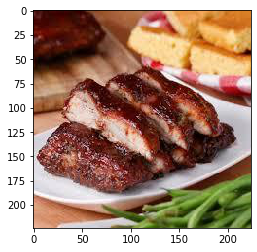

In [78]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[vgg_transfer.predict(img).argmax(axis=-1)[0]])

Actual: bibimbap_1.jpg
Predicted: bibimbap


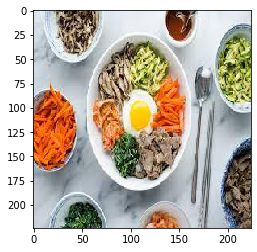

In [80]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[vgg_transfer.predict(img).argmax(axis=-1)[0]])

Actual: beef carpaccio_8.jpg
Predicted: beef carpaccio


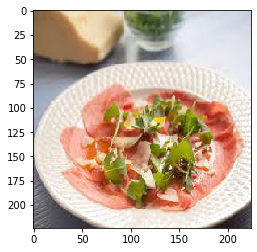

In [66]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[vgg_transfer.predict(img).argmax(axis=-1)[0]])